In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/lung-cancer-histopathological-images")

print("Path to dataset files:", path)

100%|██████████| 1.55G/1.55G [00:23<00:00, 71.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from sklearn.model_selection import train_test_split
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [3]:
import os
data_path = '/root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1'
print(os.listdir(data_path))

['squamous_cell_carcinoma', 'adenocarcinoma', 'benign']


In [4]:
import os

def count_files_in_folders(path):
    # Dictionary to store the number of files in each folder
    folder_file_count = {}

    # Loop through each item in the specified path
    for root, dirs, files in os.walk(data_path):
        # Count the files in the current directory
        num_files = len(files)

        # Store the count in the dictionary with the folder name as the key
        folder_file_count[root] = num_files

    return folder_file_count

# Specify your path here
file_counts = count_files_in_folders(data_path)

# Print the results
for folder, count in file_counts.items():
    print(f"{folder}: {count} files")

/root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1: 0 files
/root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1/squamous_cell_carcinoma: 5000 files
/root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1/adenocarcinoma: 5000 files
/root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1/benign: 5000 files


In [5]:
image_dir = Path(data_path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.[jJ][pP][gG]')) + list(image_dir.glob(r'**/*.[pP][nN][gG]'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

[14984 10722  5845  9128 14643  9687 13600  5631 11822  2402  7398 13072
  9189 11542 13737 12389]


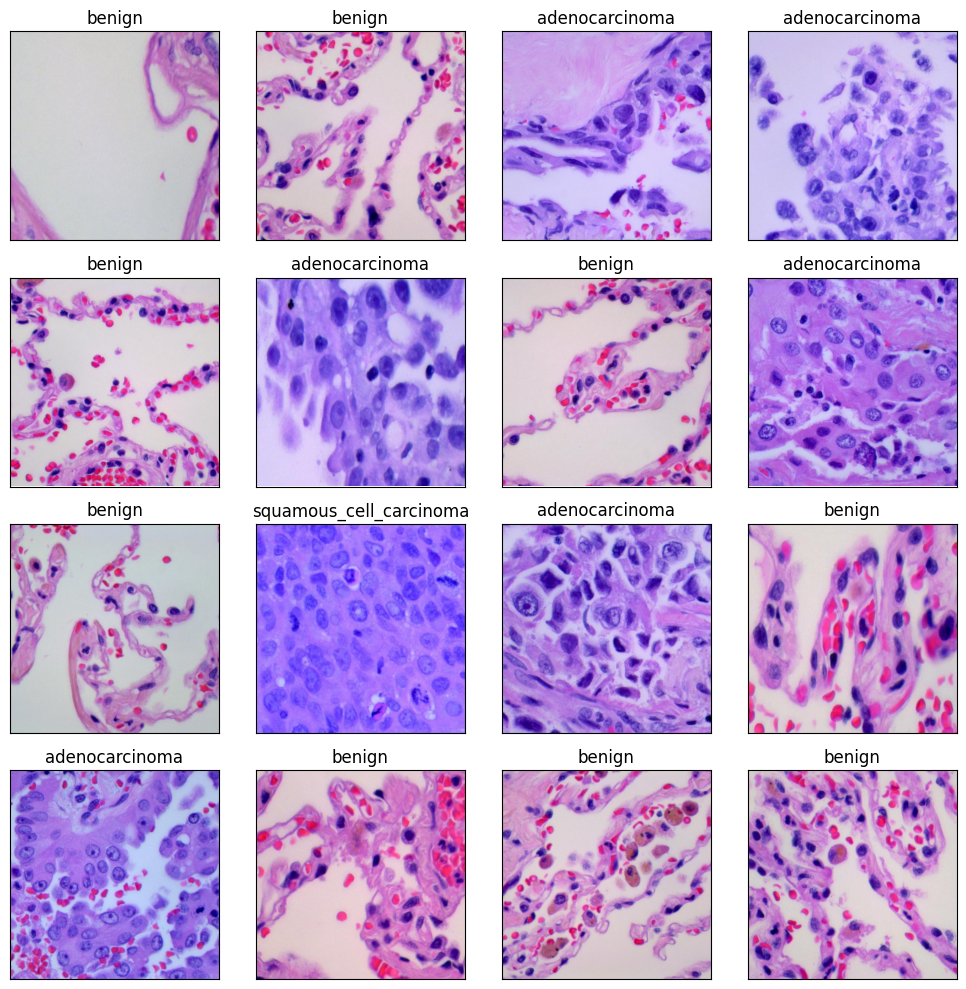

In [6]:
random_index = np.random.randint(0, len(image_df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [7]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_df.shape

(12000, 2)

In [8]:
test_df.shape


(3000, 2)

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

test_set = ImageDataGenerator(
    rescale=1./255,
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Split the data into three categories.
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)


test_images = test_set.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 9600 validated image filenames belonging to 3 classes.
Found 2400 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


In [10]:
from tensorflow.keras.applications import VGG19, InceptionV3
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2

# Load the EfficientNetB4 base model
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude the top classification layer
    weights='imagenet'  # Use pre-trained weights
)

# Freeze the base model to prevent training its weights
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Use GAP instead of Flatten for better generalization
    layers.Dense(512, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(3, activation='softmax')  # Output layer (3 classes)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=3,         # Number of epochs with no improvement before stopping
    restore_best_weights=True # Restore model weights from the epoch with the best value
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # Monitor validation loss
    factor=0.5,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement before reducing
    min_lr=1e-6           # Minimum learning rate
)

history = model.fit(
    train_images,
    epochs=10,  # Increase epochs as needed
    validation_data=val_images,
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 188s 578ms/step - accuracy: 0.8736 - loss: 0.3288 - val_accuracy: 0.9508 - val_loss: 0.1249
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 179s 585ms/step - accuracy: 0.9315 - loss: 0.1656 - val_accuracy: 0.9488 - val_loss: 0.1241
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 196s 567ms/step - accuracy: 0.9438 - loss: 0.1479 - val_accuracy: 0.9504 - val_loss: 0.1131
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 174s 570ms/step - accuracy: 0.9451 - loss: 0.1438 - val_accuracy: 0.9558 - val_loss: 0.1071
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 203s 570ms/step - accuracy: 0.9547 - loss: 0.1182 - val_accuracy: 0.9613 - val_loss: 0.0936
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 202s 575ms/step - accuracy: 0.9478 - loss: 0.1324 - val_accuracy: 0.9633 - val_loss: 0.0938
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 200s 566ms/step - accuracy: 0.9564 - loss: 0.1199 - val_accuracy: 0.9667 - val_loss: 0.0832
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 203s 571ms/step - accuracy: 0.9568 - loss: 0.10

In [12]:
loss, accuracy = model.evaluate(val_images)
print(f"Validation Accuracy:{accuracy * 100:.2f}%")

75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 507ms/step - accuracy: 0.9599 - loss: 0.0930
Validation Accuracy:95.67%


In [13]:
#Training set Accuracy
train_loss, train_acc = model.evaluate(train_images)
print(f"Training accuracy:{train_acc * 100:.2f}%")

300/300 ━━━━━━━━━━━━━━━━━━━━ 144s 478ms/step - accuracy: 0.9590 - loss: 0.0954
Training accuracy:96.31%


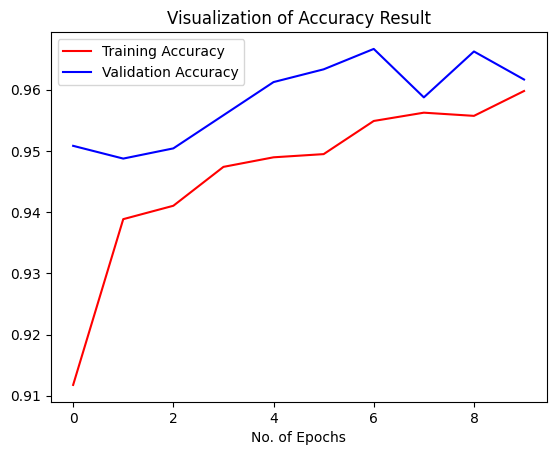

In [14]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy,color='red', label='Training Accuracy')
plt.plot(epochs, val_accuracy,color='blue', label='Validation Accuracy')
plt.title('Visualization of Accuracy Result')
plt.xlabel('No. of Epochs')
plt.legend();
plt.show()



In [15]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step


In [16]:
# Display the result
print(f'The first 10 predictions: {pred[:10]}')

The first 10 predictions: ['benign', 'adenocarcinoma', 'benign', 'squamous_cell_carcinoma', 'adenocarcinoma', 'adenocarcinoma', 'squamous_cell_carcinoma', 'squamous_cell_carcinoma', 'squamous_cell_carcinoma', 'squamous_cell_carcinoma']


In [17]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
print(df)

                         precision    recall  f1-score  support
adenocarcinoma            0.997481  0.816495  0.897959   970.00
benign                    0.998994  1.000000  0.999497   993.00
squamous_cell_carcinoma   0.853960  0.998071  0.920409  1037.00
accuracy                  0.940000  0.940000  0.940000     0.94
macro avg                 0.950145  0.938189  0.939288  3000.00
weighted avg              0.948372  0.940000  0.939328  3000.00


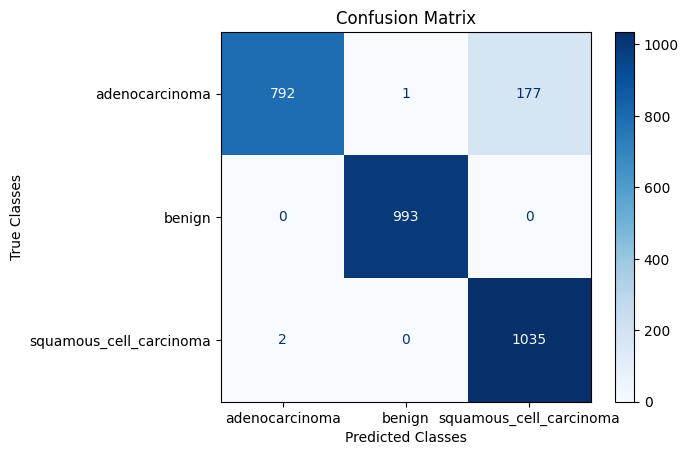

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test and pred are defined
cm = confusion_matrix(y_test, pred)

# Define your class names
class_names = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']  # Replace with your actual class names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Change the color to blue
disp.plot(cmap='Blues')

plt.xlabel('Predicted Classes')  # Optional: add x-axis label
plt.ylabel('True Classes')        # Optional: add y-axis label
plt.title('Confusion Matrix')     # Optional: add title

plt.show()